# Socket communications for IoT
## 측정한 signal의 값은 noise를 포함한다.
Sensor로 읽은 값은 noise가 포함되어 있기 때문에 변화가 있고, 실제 값을 추정하기가 곤란하다. 

아래 그림은 실제 값은 sine curve지만(`signal`), gausian noise가 더해져서 변화 무쌍하다(`measured`). 실제 우리가 측정하는 sensor data는 이런 값이 추출된다.

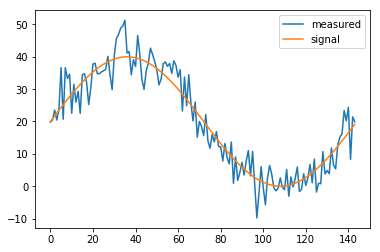

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Fs = 24 * 6
f = 1
sample = Fs

t = np.arange(sample)
k = 0.5
avg = 20
a = 20
signal = a * np.sin(2 * np.pi * f * t / Fs) + avg
noise = np.random.normal(scale=a/4, size=len(signal))
measured = signal + noise
df = pd.DataFrame({'signal': signal, 'measured': measured} )
df.plot()
plt.show()

측정된 값으로 실제 값을 알아낼 수는 없다. 하지만, 과거 측정값의 추이를 감안하여 새로 측정한 값을 원래 값에 가깝도록 보정할 수는 있다.Moving average가 그것이며, 최근 값은 가중치를 높게, 먼 과거일수록 가중치를 낮추는 EWMA(Exponential Weighted Moving Average)가 널리 사용되고 있다. 

아래 `smooth` curve는 EWMA로 보정한 moving average를 plotting한 것이다. Measured signal 보다 smoothing되었고, 실체 sine curve에 보다 가까움을 알 수 있다. (Mean square error가 작다.) 즉, 비교적 noise가 제거되었음을 확인할 수 있다.

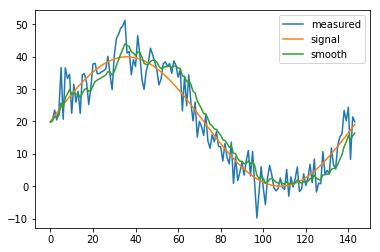

In [39]:
df['smooth'] = df['measured'].ewm(span=10).mean()
df.plot()
plt.show()

## Sensor data의 측정과 EWMA smoothing

In [83]:
import random, math

random.seed(113)
def gen_data(mean, deviation, samples=100):
    """Simulate reading sensor's data, adding noise to sine curve.
    
    :param mean: mean of sine curve
    :param deviation: deviation of sine curve
    :param samples: total number of samples to be generated
    :return: sensor data (float)
    """

    # Get values from the sensors
    Fs = samples
    f = 1
    for t in range(samples):
        signal = deviation * math.sin(2 * math.pi * f * t / Fs) + mean
        noise = random.gauss(mu=deviation/4, sigma=deviation/4)
        measured = signal + noise
        yield measured
        
gen_temp = gen_data(mean=20, deviation=20, samples=10)
gen_humid = gen_data(mean=50, deviation=15, samples=10)
for t in gen_temp:
    print(t)
print()
# You may use while loop
while True:
    try:
        h = next(gen_humid)
    except StopIteration:
        break
    print(h)

34.87027242184287
38.67427650219527
43.85537143215785
43.08608890988933
33.243434402696536
23.8603468410409
20.462445318542073
-0.6507255792784008
3.824963066362121
19.64669145825141

50.70248991705674
62.663946931305915
64.58523025136148
69.5496287429662
53.51610309894643
55.627529094123474
44.80679911031533
38.44388744498316
33.58309382470726
52.80488984867783


In [102]:
def ewma(generator, alpha=0.25):
    s = None
    for y in generator:
        if s:
            s = alpha*y + (1-alpha)*s
        else:
            s = y
        yield s

gen_temp = gen_data(mean=20, deviation=20, samples=10)
gen_humid = gen_data(mean=50, deviation=15, samples=10)
smooth_temp_data = [t for t in ewma(gen_temp)]
smooth_humid_data = [h for h in ewma(gen_humid)]
print(smooth_temp_data)
print(smooth_humid_data)

[25.146203095067566, 29.935993300522576, 34.77612243333718, 33.92824885561752, 33.65679499992107, 29.52831084524808, 24.05135660122431, 20.700211032260405, 20.62110960364492, 17.623912740642325]
[49.46403315882795, 53.873641725940104, 56.08950472963947, 60.65354514289841, 59.0649013372132, 59.21592622065003, 55.69960238179461, 50.94496404981478, 47.414879665111854, 47.67135028628219]


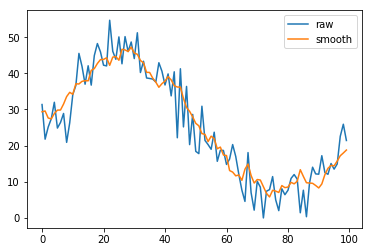

In [103]:
raw_temp = [t for t in gen_data(mean=20, deviation=20, samples=100)]
smooth_temp = [t for t in ewma(gen_data(mean=20, deviation=20, samples=100))]
df = pd.DataFrame({'raw': raw_temp, 'smooth': smooth_temp} )
df.plot()
plt.show()